In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import torch.utils.data as Data

In [4]:
ds = pd.read_csv('./mnist_train.csv').values
print (ds.shape)

(60000, 785)


In [7]:
X_train = ds[:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = ds[5000:5100, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_test = ds[5000:5100, 0]

print (X_train.shape, y_train.shape)

(10000, 1, 28, 28) (10000,)


In [8]:
class CAE(torch.nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = CAE()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_func = nn.MSELoss()

In [15]:
def make_batch(train, labels, batch_size=10):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True), Variable(torch.FloatTensor(train[start:stop]))
        start = stop
        stop = start + batch_size

In [17]:
for epoch in range(20):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 256)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = model(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in model.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if step % 200 == 0:
            test_output = model(torch.FloatTensor(X_test))
            test_loss = loss_func(test_output, torch.FloatTensor(X_test))
            acc = test_loss.data.numpy()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

Epoch:  0 | Step:  0 | Acc:  0.029896302
Epoch:  1 | Step:  0 | Acc:  0.03000486
Epoch:  2 | Step:  0 | Acc:  0.029992312
Epoch:  3 | Step:  0 | Acc:  0.029919626
Epoch:  4 | Step:  0 | Acc:  0.02976696
Epoch:  5 | Step:  0 | Acc:  0.029764485
Epoch:  6 | Step:  0 | Acc:  0.029643144
Epoch:  7 | Step:  0 | Acc:  0.029554475
Epoch:  8 | Step:  0 | Acc:  0.02945656
Epoch:  9 | Step:  0 | Acc:  0.029476
Epoch:  10 | Step:  0 | Acc:  0.02940036
Epoch:  11 | Step:  0 | Acc:  0.029368952
Epoch:  12 | Step:  0 | Acc:  0.029312255
Epoch:  13 | Step:  0 | Acc:  0.029225271
Epoch:  14 | Step:  0 | Acc:  0.029187202
Epoch:  15 | Step:  0 | Acc:  0.02907743
Epoch:  16 | Step:  0 | Acc:  0.02903144
Epoch:  17 | Step:  0 | Acc:  0.028934274
Epoch:  18 | Step:  0 | Acc:  0.028862402
Epoch:  19 | Step:  0 | Acc:  0.02880031


In [18]:
o = model(torch.FloatTensor(X_train[:100])).data.numpy()

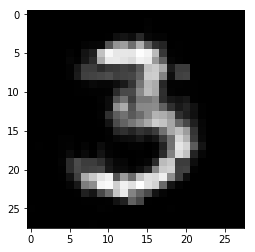

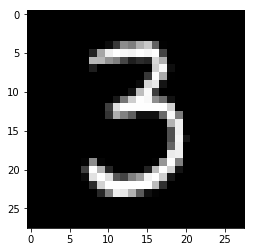

In [21]:
plt.figure(0)
plt.imshow(o[50].reshape((28, 28)), cmap='gray')

plt.figure(1)
plt.imshow(X_train[50].reshape((28, 28)), cmap='gray')

# Overfitting